In [9]:
import os
import pandas as pd               
import matplotlib.pyplot as plt  
plt.style.use('bmh')

variable_dir_dict = {
    'seq_length': 'Sequence Length',
    'lora_rank': 'Rank',
    'learning_rate': 'Learning Rate',
    'batch_size': 'Batch Size',
    'target_modules': 'Target Modules',
}

def read_df_and_save_plot(variable_dir, indices_loss, indices_mem, drop_min_max = True, legend_labels_loss = None, legend_labels_mem = None):
    type_loss = 'loss'
    type_mem = 'mem'
    df_loss = read_indices_from_dir(variable_dir, type_loss, indices_loss, drop_min_max)
    df_mem = read_indices_from_dir(variable_dir, type_mem, indices_mem, drop_min_max)
    df_mem['bytes'] = df_mem['bytes'] / 1e9
    df_mem['runtime'] = df_mem['runtime'] / 60
    fig, ax = plt.subplots(figsize = (24, 8))
    fig_save_path = f"figures/loss_all_{variable_dir}.pdf"
    if not os.path.exists(os.path.dirname(fig_save_path)):
        os.makedirs(os.path.dirname(fig_save_path))

    variable_dir = variable_dir_dict[variable_dir]
    fig, ax = plot_loss_line_plot(df_loss, fig, ax, variable_dir, font_size=24, save_path = fig_save_path, legend_labels= legend_labels_loss)
    

    # fig, axes = plt.subplots(1, 2, figsize = (24, 8))
    # ax1, ax2 = axes
    fig, ax1 = plt.subplots(figsize = (24, 8))
    ax2 = ax1.twinx()
    fig_save_path = f"figures/mem_runtime_all_{variable_dir}.pdf"
    if not os.path.exists(os.path.dirname(fig_save_path)):
        os.makedirs(os.path.dirname(fig_save_path))
    fig, ax1, ax2 = plot_memory_runtime_line_plot(df_mem, fig, ax1, ax2, variable_dir, font_size=24, save_path = fig_save_path, legend_labels= legend_labels_mem)
    return df_loss, df_mem


def read_csv_from_dir(variable_dir, index, type, drop_min_max=False):
    csv_path = f'./{variable_dir}/{type}_{index}.csv'
 
    df = pd.read_csv(csv_path)
 
    if type == 'loss':
        new_cols = ['step', 'loss', 'loss_MIN', 'loss_MAX']
        new_cols = [f'{variable_dir}_{index}_{col}' for col in new_cols]
        df.columns = new_cols
        if drop_min_max:
            df = df.drop(columns=new_cols[2:])
    elif type == 'mem':
        new_cols = ['step', 'runtime', 'runtime_MIN', 'runtime_max', 'bytes', 'bytes_MIN', 'bytes_MAX']
        new_cols = [f'{variable_dir}_{index}_{col}' for col in new_cols]
        df.columns = new_cols
        if drop_min_max:
            df = df.drop(columns=new_cols[2:4] + new_cols[5:])

 
    return df

def read_indices_from_dir(variable_dir, type, indices, drop_min_max=False):
    dfs = []
    for index in indices:
        df = read_csv_from_dir(variable_dir, index, type, drop_min_max)
        dfs.append(df)
    df = pd.concat(dfs, axis=1)
    columns = df.columns
    steps_cols = [col for col in columns if 'step' in col]
    if type == 'loss':
        first_steps = df[steps_cols[0]]
        same_steps = True
        for steps_col in steps_cols[1:]:
            steps = df[steps_col]
            if not steps.equals(first_steps):
                same_steps = False
                break
        if same_steps:
            df = df.drop(columns=steps_cols[1:])
            df = df.rename(columns={steps_cols[0]: 'step'})
    elif type == 'mem':
        df = df.drop(columns=steps_cols)
        data = {'runtime': [], 'bytes': [], 'model': []}
        columns = df.columns
        for col in columns:
            key = col.split('_')[-1]
            index = col.split('_')[-2]
            data[key].append(df[col].values[0])
            if key == 'bytes':
                data['model'].append(f'{variable_dir}_{index}')
        df = pd.DataFrame(data)
            
    return df



In [12]:
import numpy as np
def plot_loss_line_plot(df, fig, ax1, variable_dir='Ablation Variable',
                        width=0.35, font_size=24, save_path=None,
                        legend_labels=None, title=None):
    #Line plot with x axis as step and multiple lines for each model


    x = df['step']
    columns = df.columns
    columns = [col for col in columns if 'loss' in col]
    for col in columns:
        y = df[col]
        ax1.plot(x, y, label=col, linewidth=3)

    ax1.set_xlabel('Step', fontsize = font_size)
    ax1.set_ylabel('Loss', fontsize = font_size)
    if title is None:
        ax1.set_title("Loss vs. " + variable_dir, fontsize = font_size)
    else:
        ax1.set_title(title, fontsize = font_size)
    if legend_labels is None:
        ax1.legend(fontsize = font_size)
    else:
        ax1.legend(legend_labels, fontsize = font_size)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = font_size)
    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    return fig, ax1


def plot_memory_runtime_line_plot(df, fig, ax1, ax2, variable_dir='Ablation Variable',
                        width=0.35, font_size=24, save_path=None,
                        legend_labels=None, title=None):
     #2 Line plots (1 plot with mirroed axis) with x axis as step and multiple lines for each model

    x = df['model']
    if legend_labels is None:
        x_ticks = [f'{variable_dir}_{i}' for i in range(len(x))]
    else:
        x_ticks = legend_labels
    columns = df.columns
    columns = [col for col in columns if 'runtime' in col]
    for col in columns:
        y = df[col]
        ax2.plot(x, y, label=col, linewidth=3, color='hotpink')

    columns = df.columns
    columns = [col for col in columns if 'bytes' in col]
    for col in columns:
        y = df[col]
        ax1.plot(x, y, label=col, linewidth=3, color='rebeccapurple')

    ax1.set_xticks(x)
    ax1.set_xticklabels(x_ticks, rotation=0, ha='right')
    ax1.set_xlabel(variable_dir, fontsize = font_size)

    ax2.set_xticks(x)
    ax2.set_xticklabels(x_ticks, rotation=0, ha='right')
    ax2.set_xlabel(variable_dir, fontsize = font_size)

    #combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.yaxis.label.set_color('rebeccapurple')
    ax2.yaxis.label.set_color('hotpink')
    ax1.tick_params(axis='y', colors='rebeccapurple')
    ax2.tick_params(axis='y', colors='hotpink')
    ax1.legend(lines + lines2, ["Memory", "Runtime"], loc='upper left', fontsize = font_size)
    ax1.set_ylim(0, df['bytes'].max()*1.25)
    ax2.set_ylim(0, df['runtime'].max()*1.25)


    #Set the number of ticks on ax1 to be the same as on ax2
    ax1.yaxis.set_major_locator(plt.MaxNLocator(len(ax2.get_yticks())))
    ax2.yaxis.set_major_locator(plt.MaxNLocator(len(ax2.get_yticks())))

    #set ax2 ticks every 10 minutes
    ax2.yaxis.set_major_locator(plt.MultipleLocator(10))
    

    #Set ax1 y ticks to 6 ticks starting at 0 and ending at the max of ax1
    ax1_yticks = np.linspace(0, 15, 6)

    #Turn off grid on ax2
    ax2.grid(False)
    


    

    ax1.set_ylabel('Memory in GB', fontsize = font_size)
    ax2.set_ylabel('Runtime in Minutes', fontsize = font_size)
    if title is None:
        ax1.set_title("Memory Runtime vs. " + variable_dir, fontsize = font_size)
    else:
        ax1.set_title(title, fontsize = font_size)

    ax1.tick_params(axis = 'both', which = 'major', labelsize = font_size)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = font_size)

    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    return fig, ax1, ax2




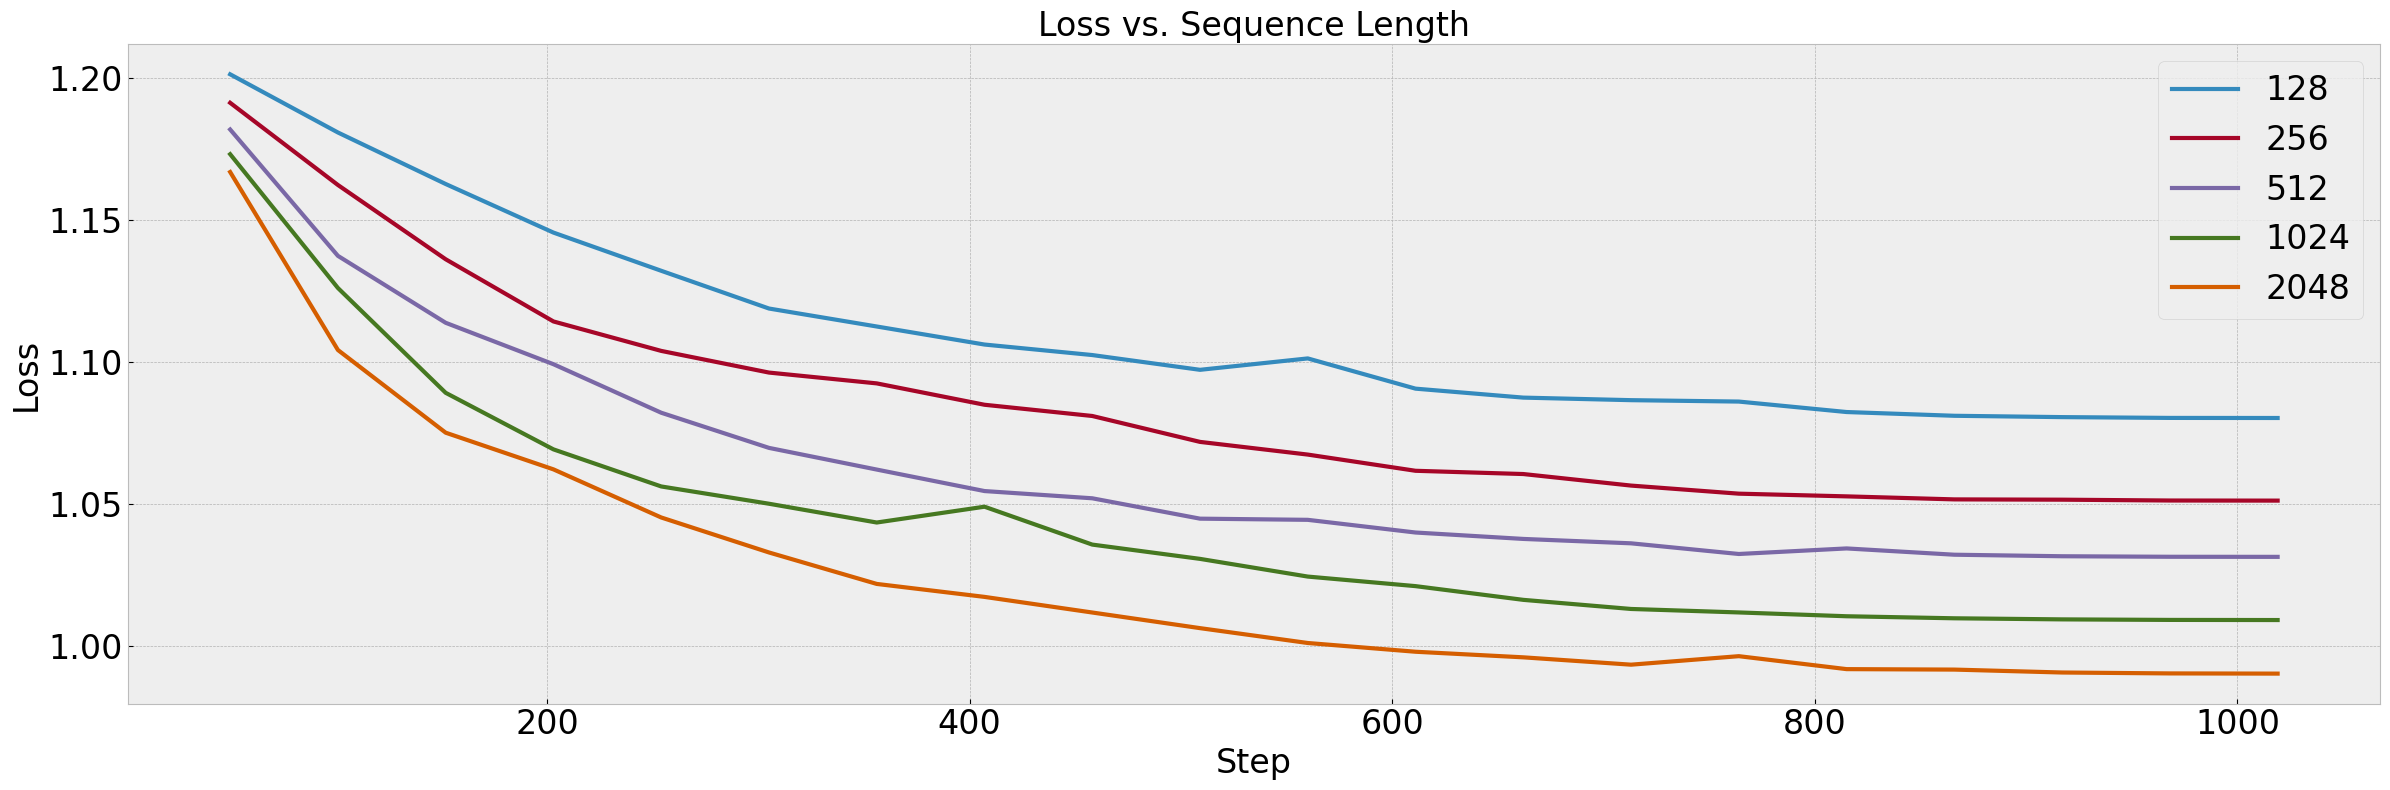

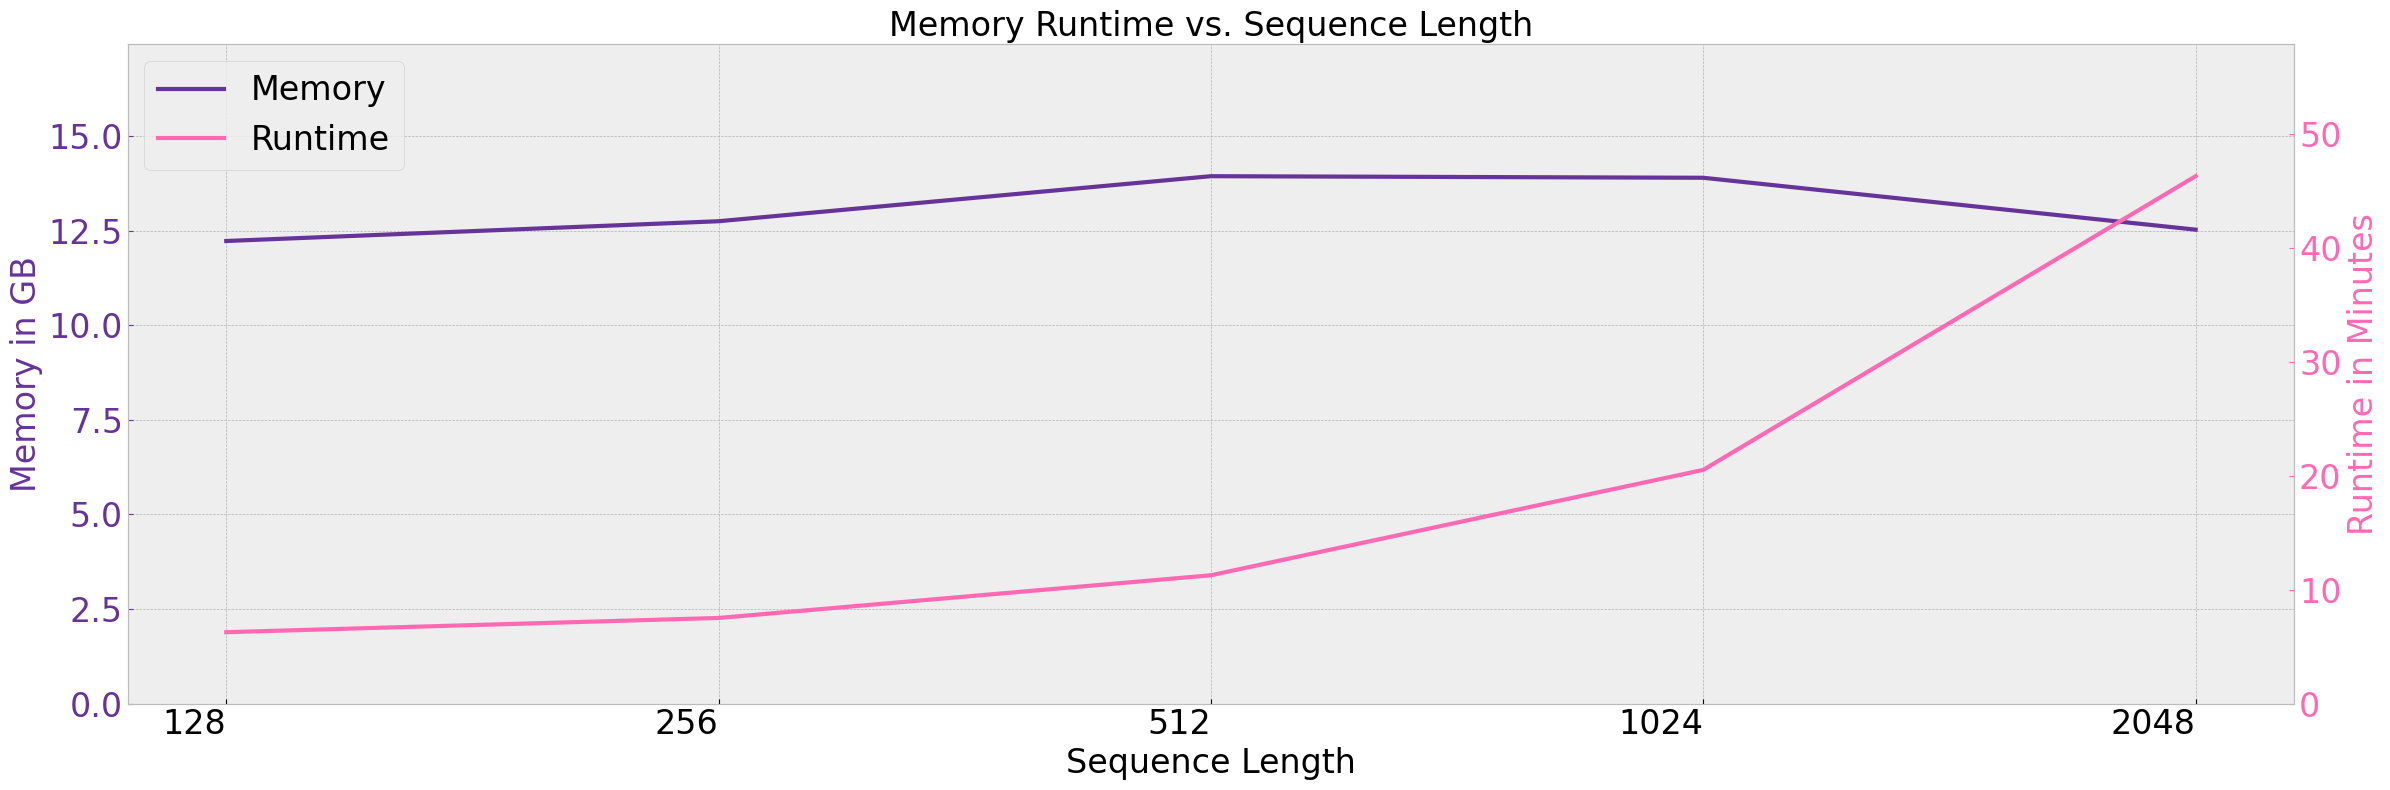

In [14]:
variable_dir = 'seq_length'
indices_loss = [0, 1, 2, 3, 4]
legend_labels_loss = ['128', '256', '512', '1024', '2048']
indices_mem = indices_loss
legend_labels_mem = legend_labels_loss
df_loss, df_mem = read_df_and_save_plot(variable_dir, indices_loss, indices_mem, legend_labels_loss = legend_labels_loss, legend_labels_mem = legend_labels_mem)

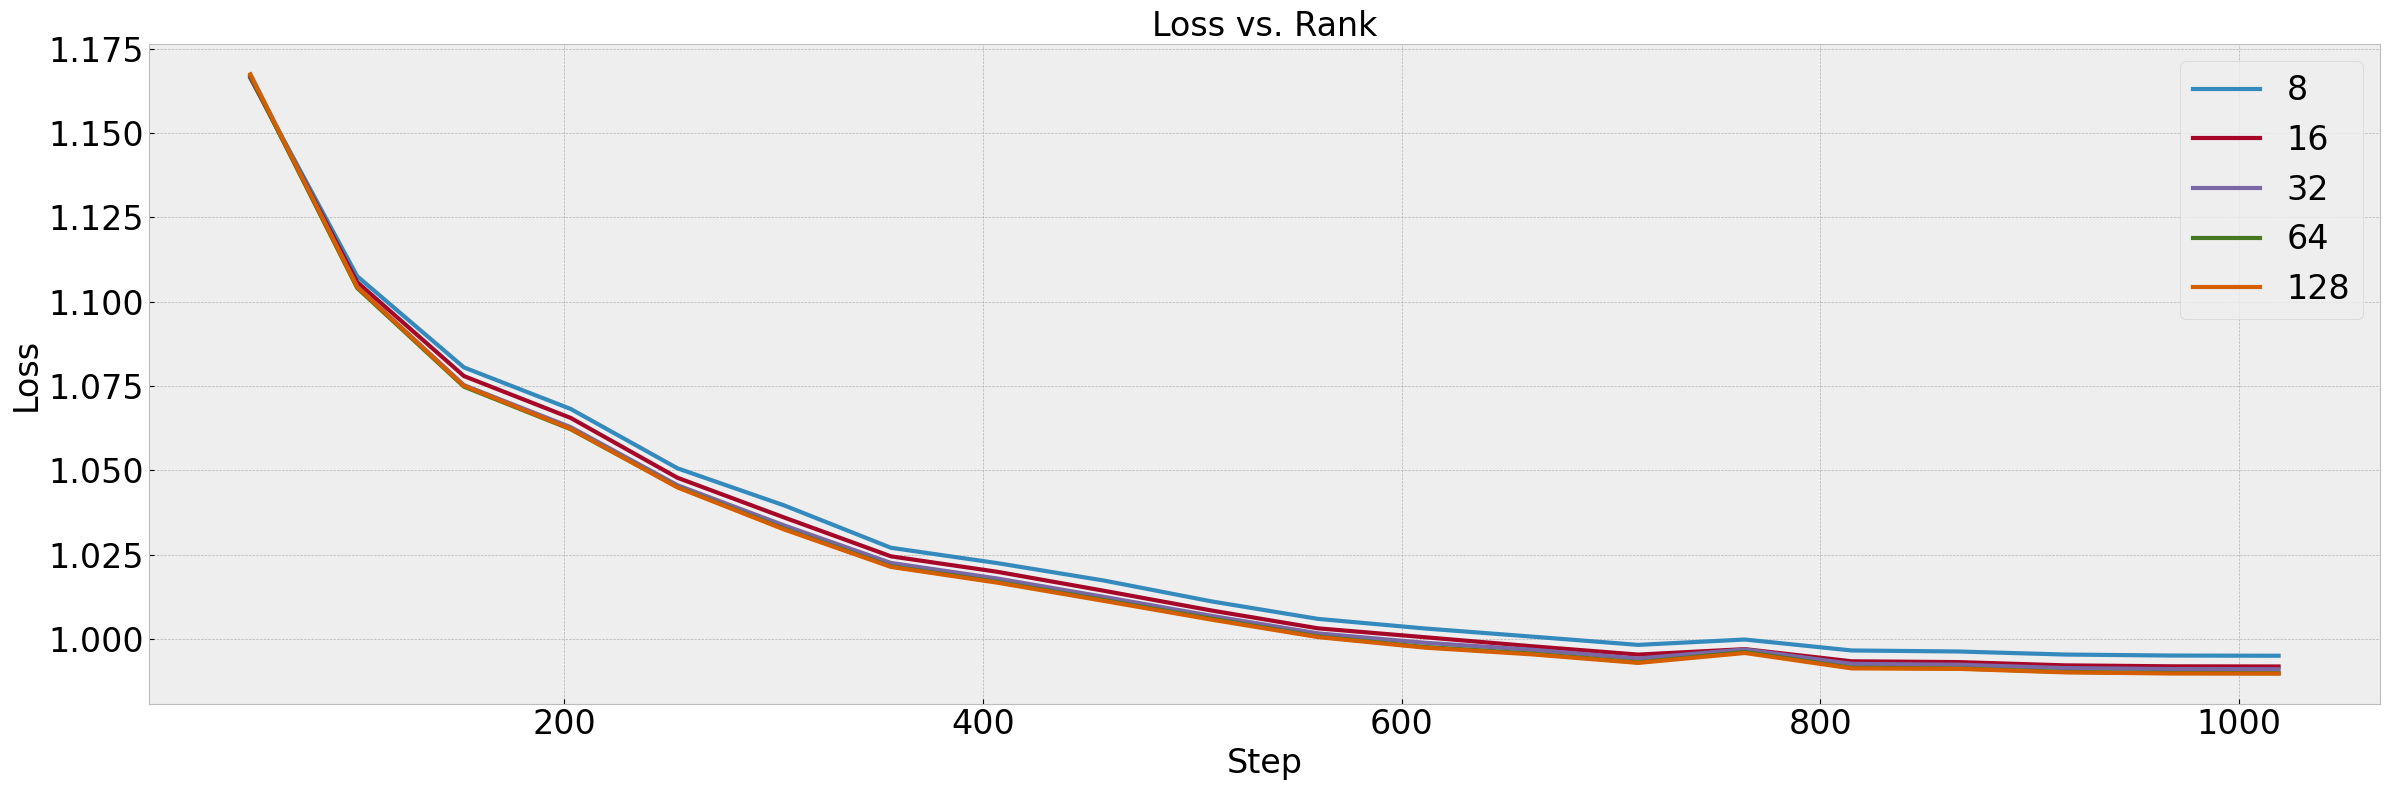

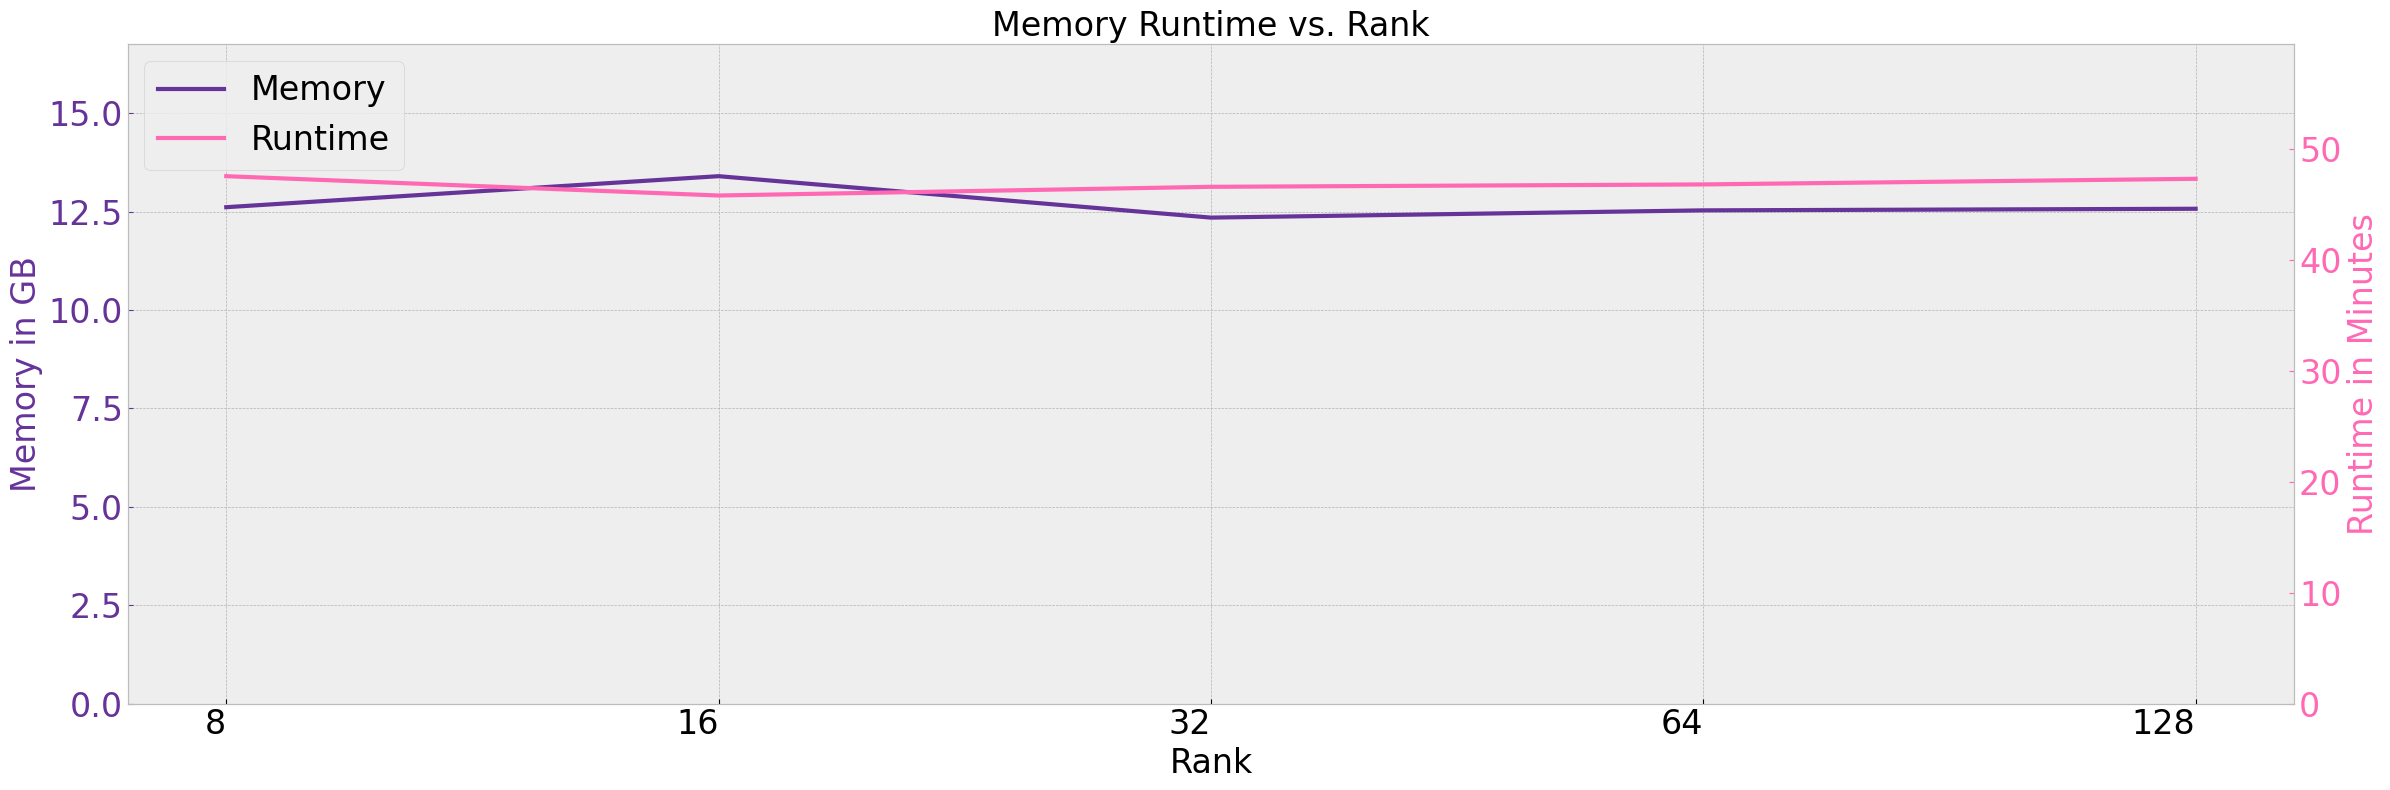

In [15]:
variable_dir = 'lora_rank'
indices_loss = [0, 1, 2, 3, 4]
legend_labels_loss = ['8', '16', '32', '64', '128']
indices_mem = indices_loss
legend_labels_mem = legend_labels_loss
df_loss, df_mem = read_df_and_save_plot(variable_dir, indices_loss, indices_mem, legend_labels_loss = legend_labels_loss, legend_labels_mem = legend_labels_mem)

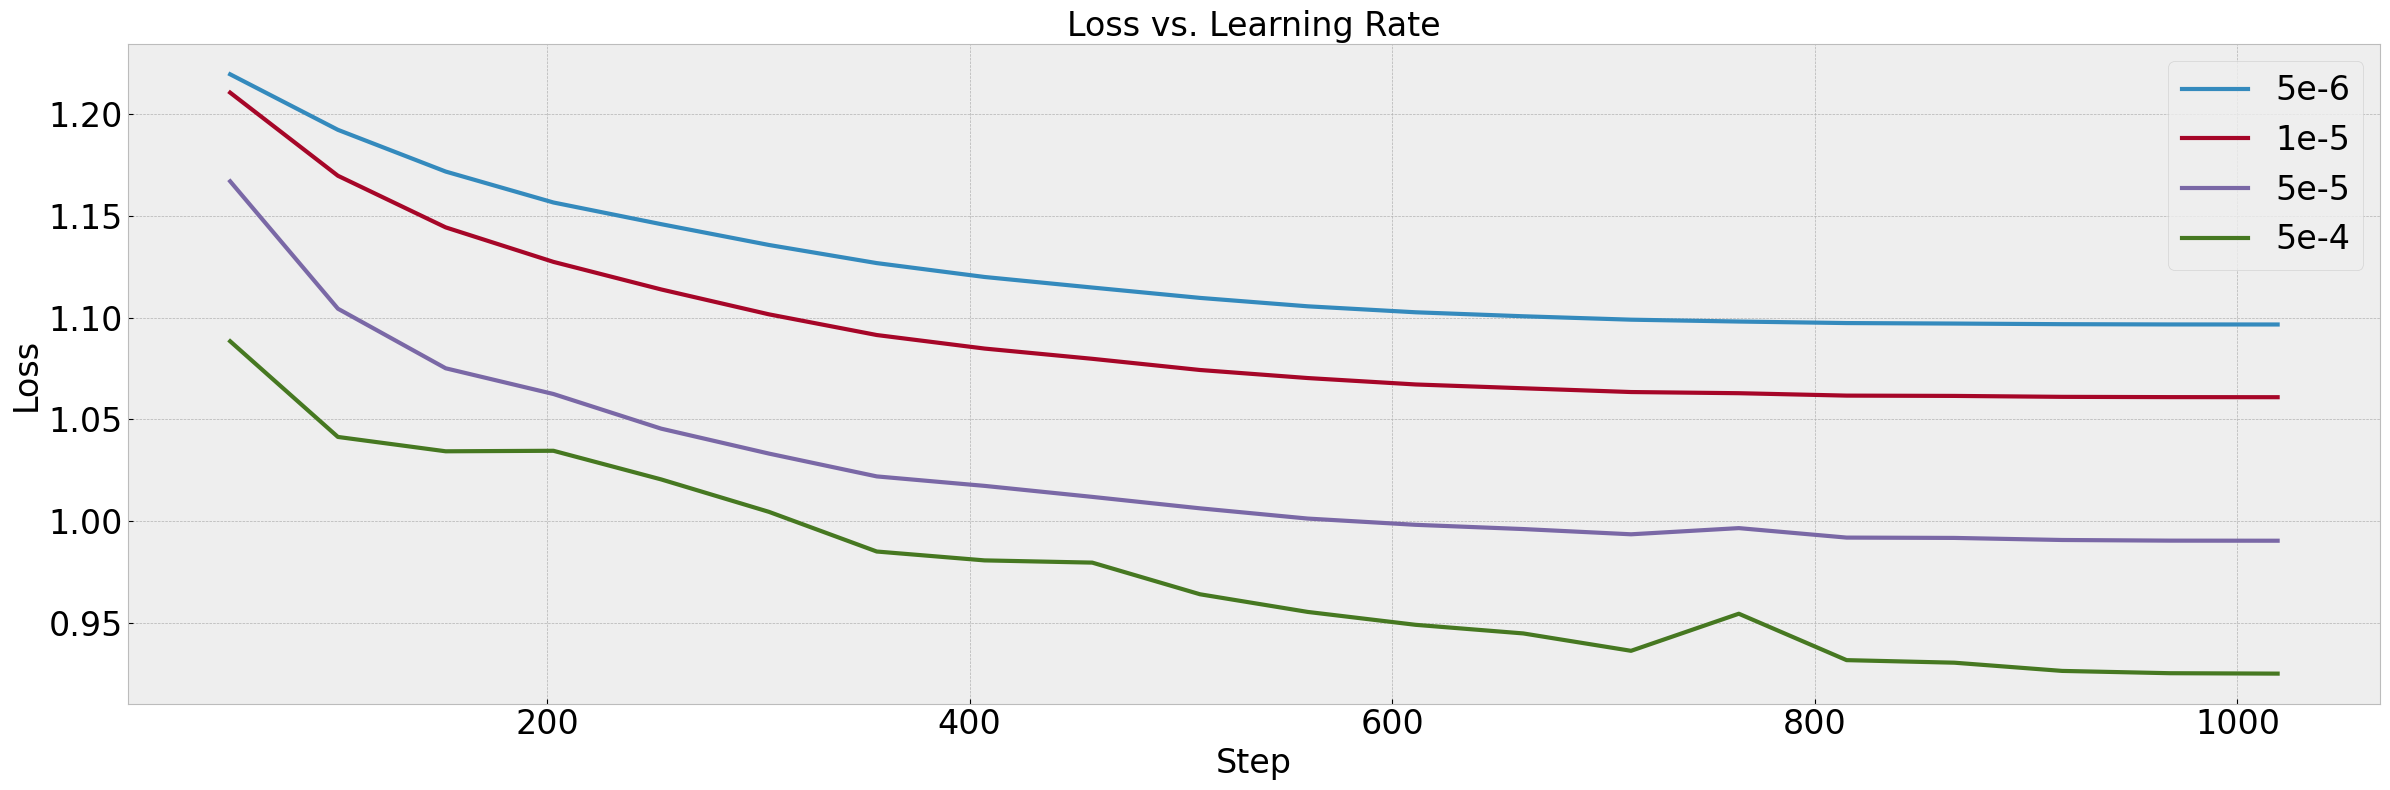

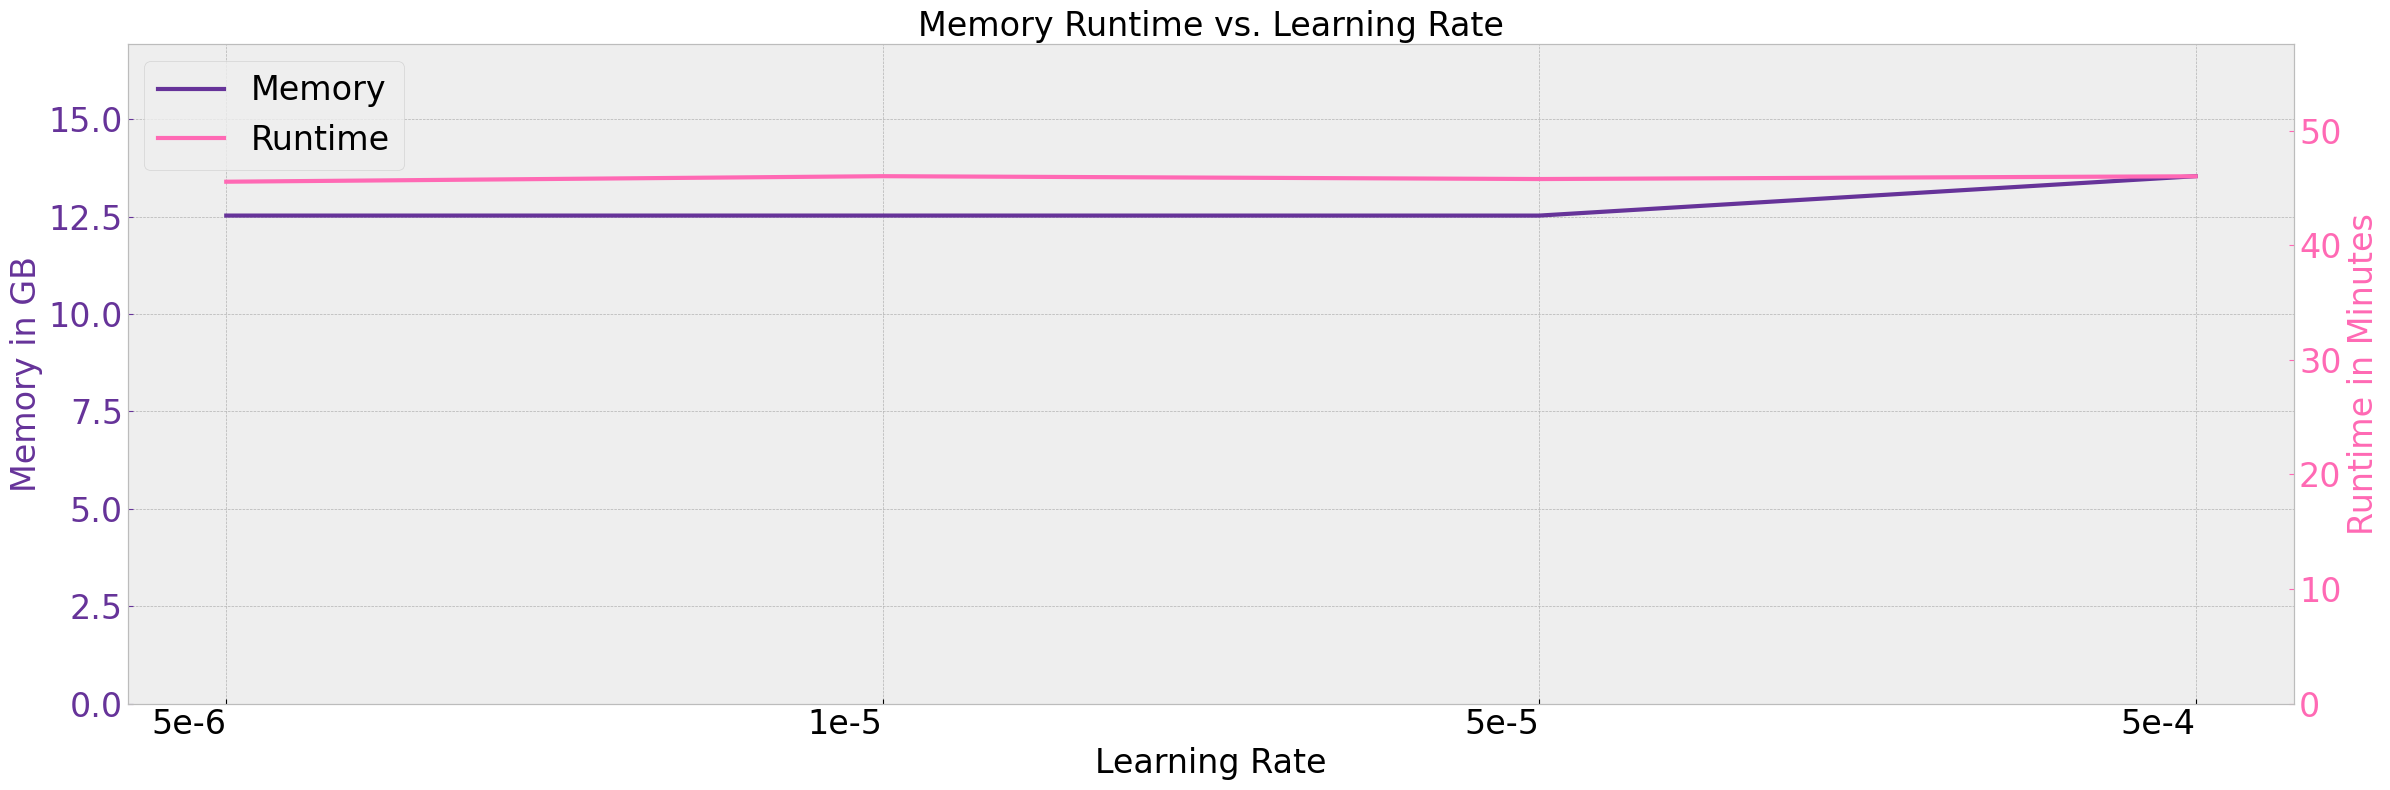

In [16]:
variable_dir = 'learning_rate'
indices_loss = [0, 1, 2, 3]
legend_labels_loss = ['5e-6', '1e-5', '5e-5', '5e-4']
indices_mem = indices_loss
legend_labels_mem = legend_labels_loss
df_loss, df_mem = read_df_and_save_plot(variable_dir, indices_loss, indices_mem, legend_labels_loss = legend_labels_loss, legend_labels_mem = legend_labels_mem)

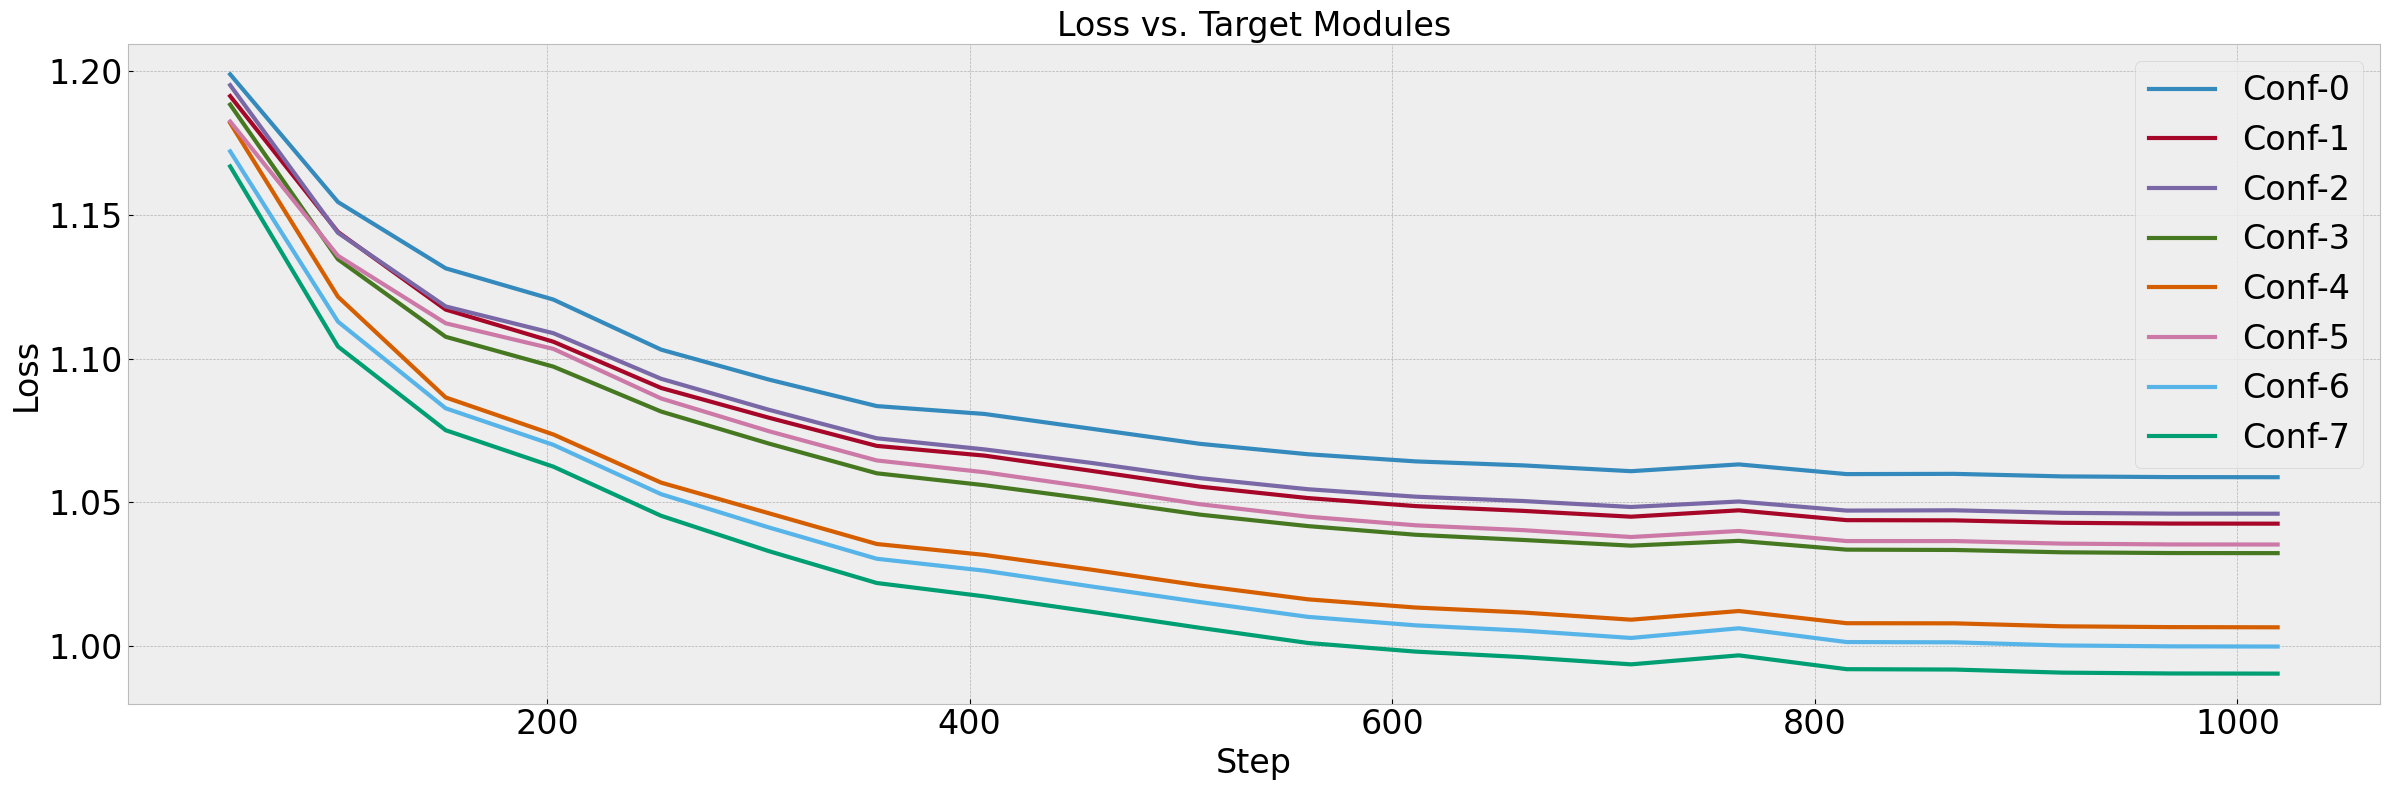

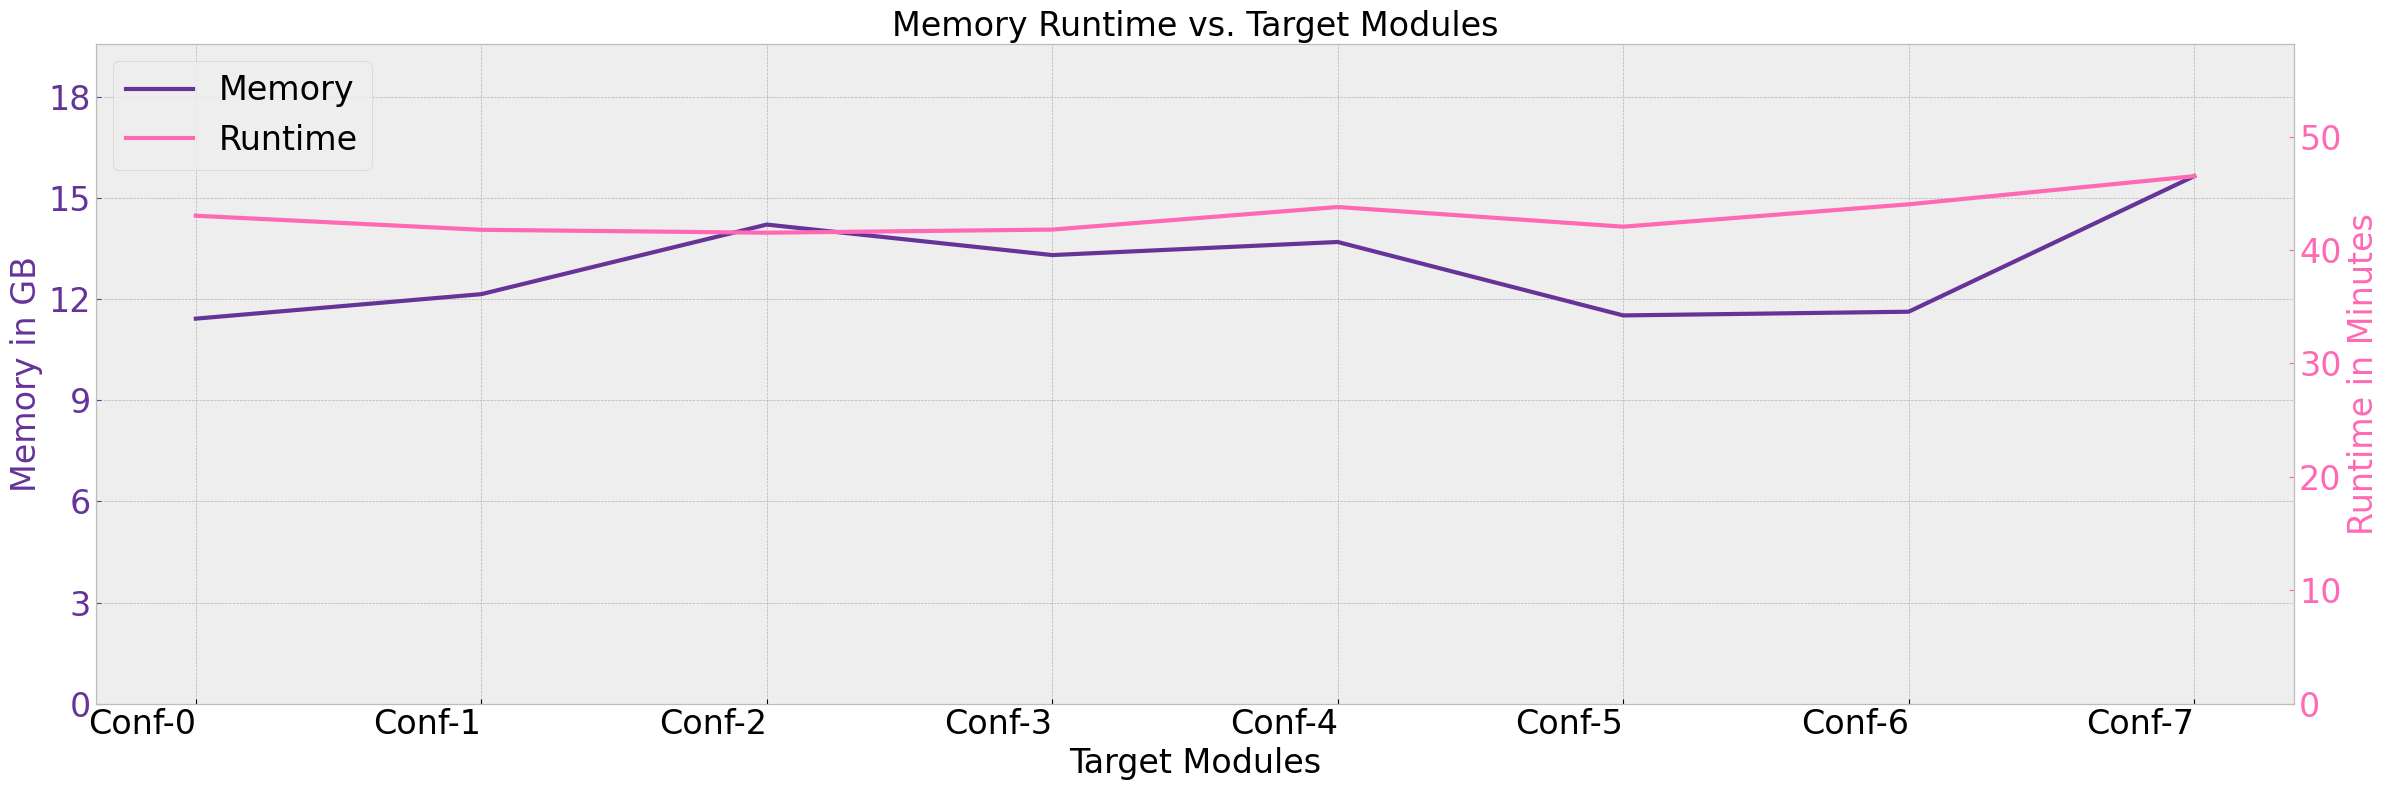

In [17]:
variable_dir = 'target_modules'
indices_loss = [0, 1, 2, 3, 4, 5, 6, 7]
legend_labels_loss = ['Conf-0', 'Conf-1', 'Conf-2', 'Conf-3', 'Conf-4', 'Conf-5', 'Conf-6', 'Conf-7']
indices_mem = indices_loss
legend_labels_mem = legend_labels_loss
df_loss, df_mem = read_df_and_save_plot(variable_dir, indices_loss, indices_mem, legend_labels_loss = legend_labels_loss, legend_labels_mem = legend_labels_mem)

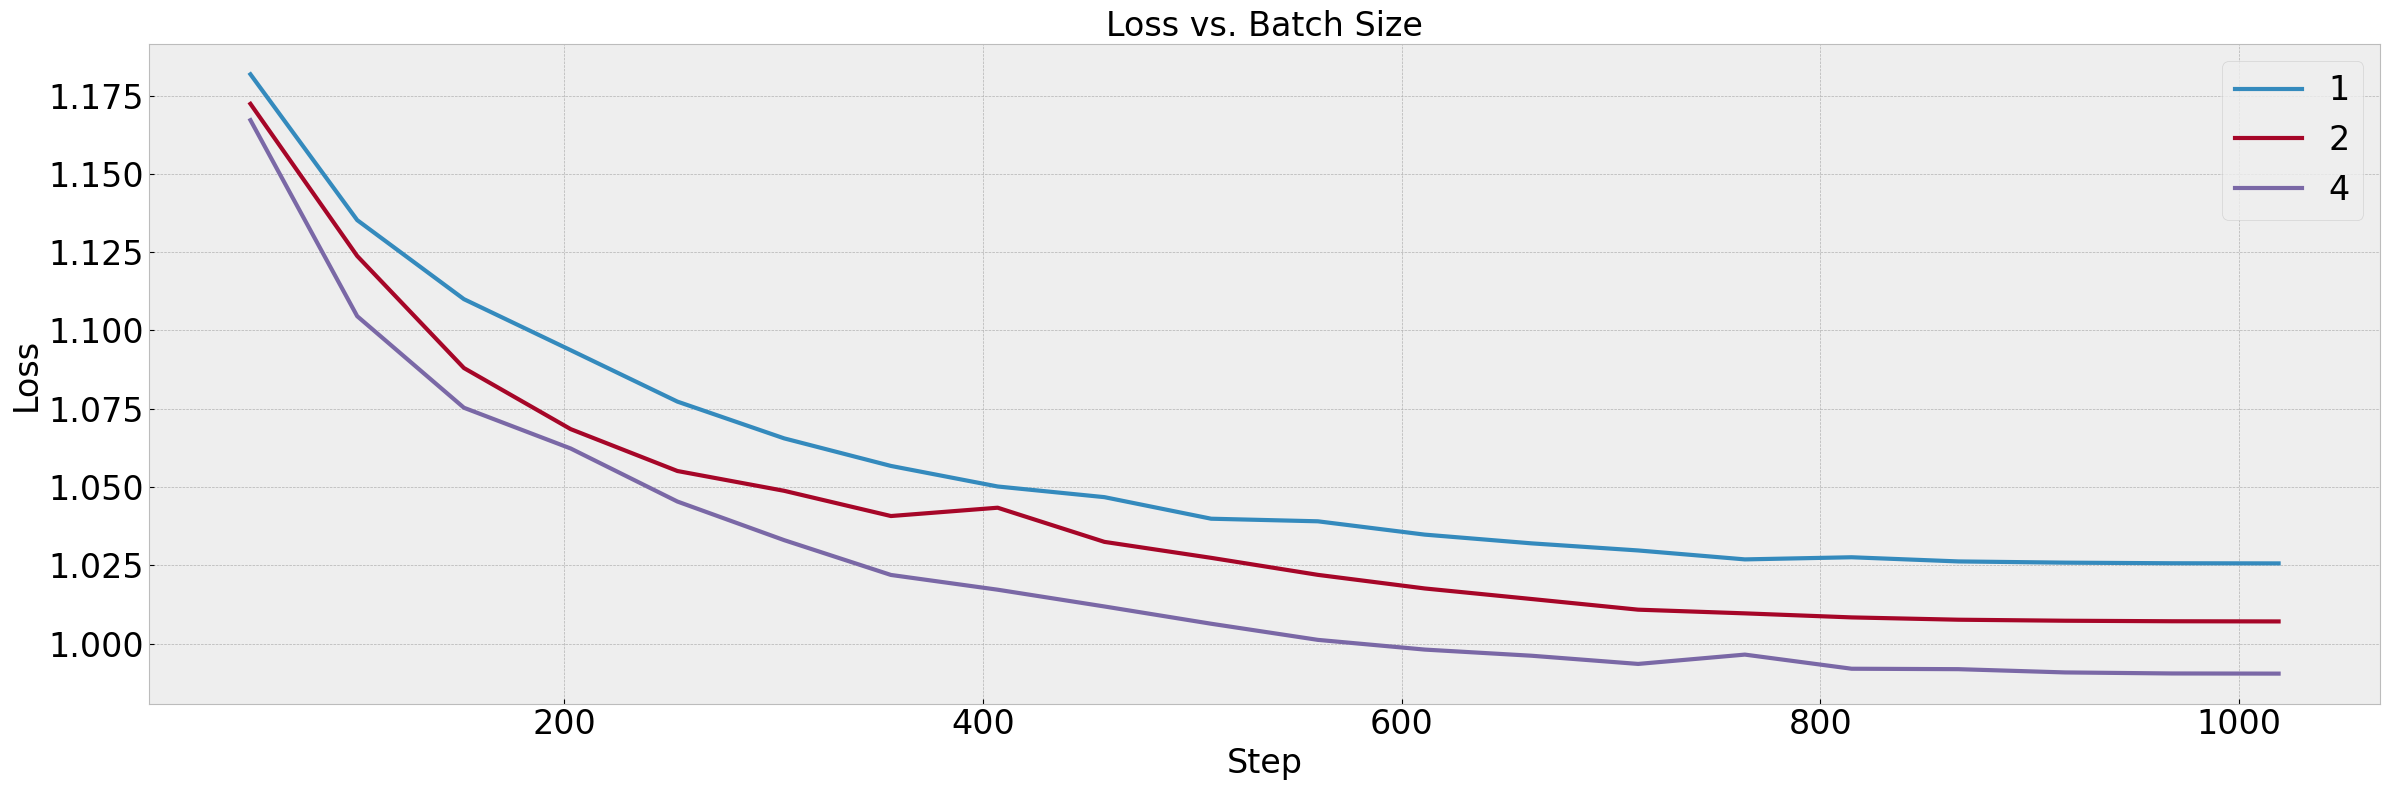

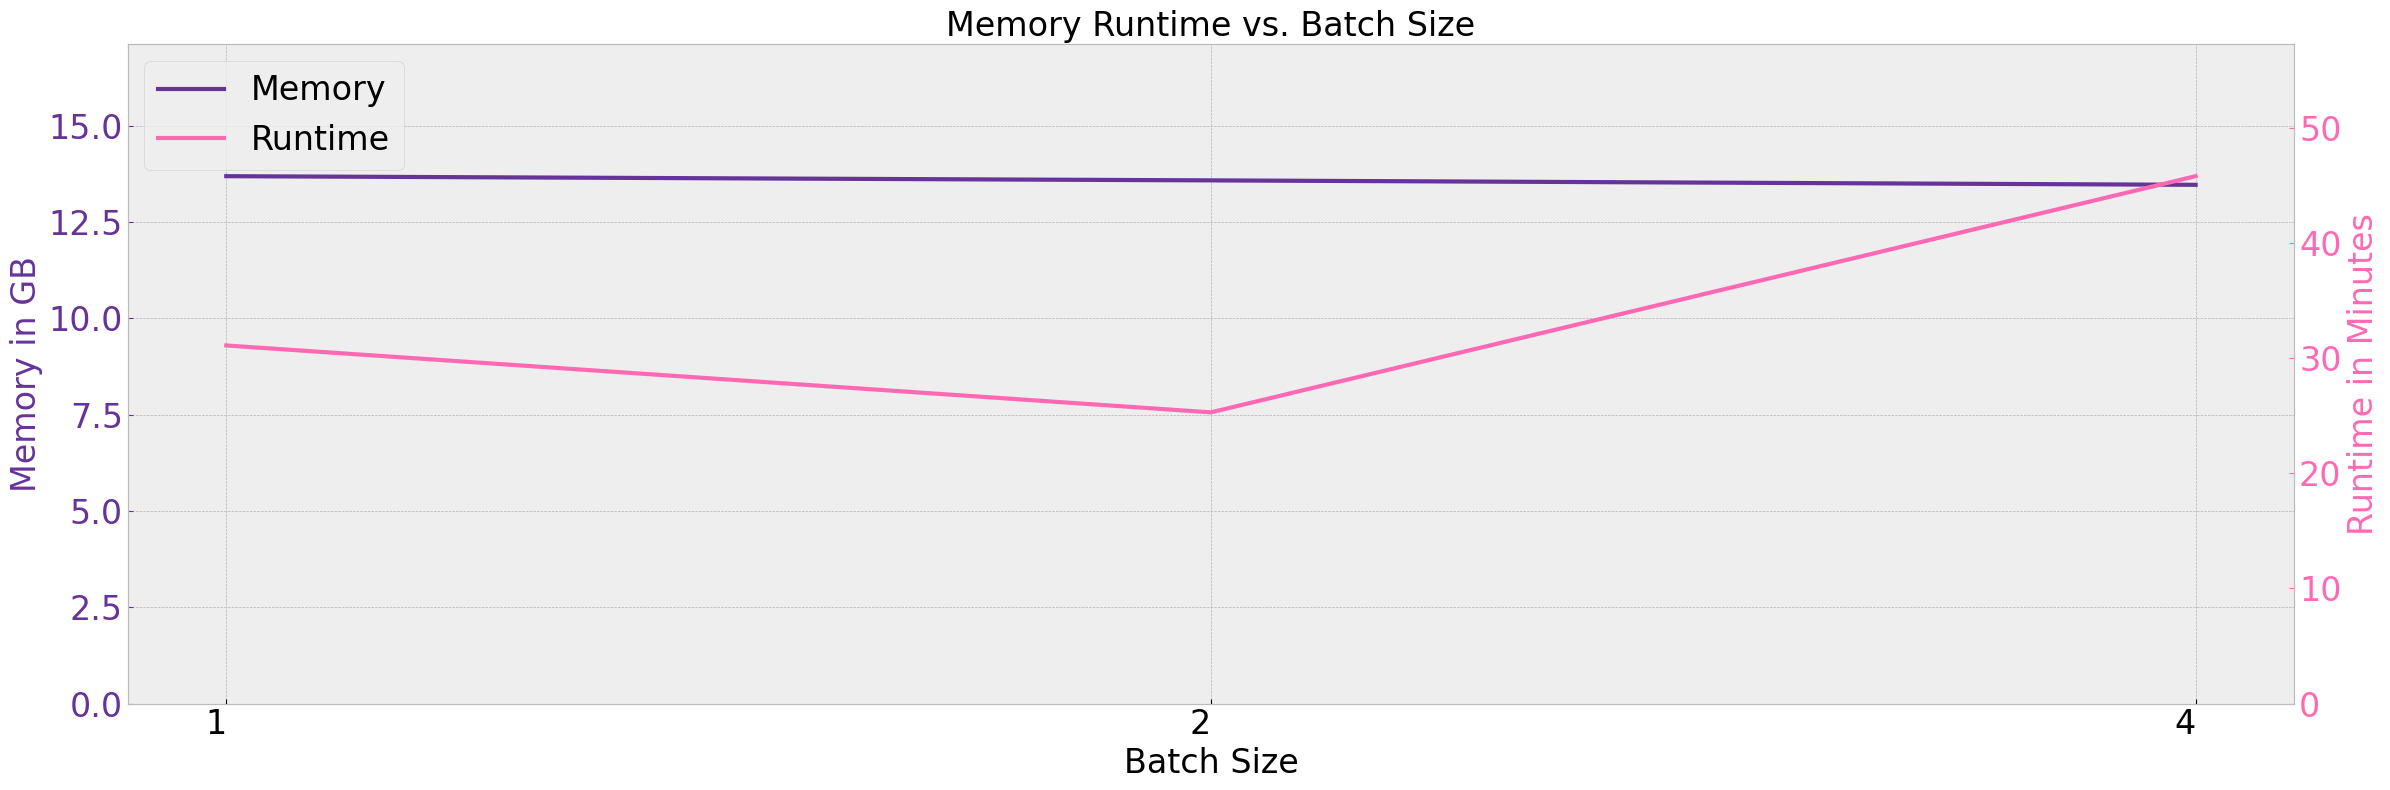

In [18]:
variable_dir = 'batch_size'
indices_loss = [0, 1, 2]
legend_labels_loss = ['1', '2', '4']
indices_mem = indices_loss
legend_labels_mem = legend_labels_loss
df_loss, df_mem = read_df_and_save_plot(variable_dir, indices_loss, indices_mem, legend_labels_loss = legend_labels_loss, legend_labels_mem = legend_labels_mem)

In [ ]:
import pandas as pd
tradeoff_df = pd.read_csv('tradeoff.csv')
tradeoff_df

In [ ]:
import pandas as pd
all_mem_df = pd.read_csv('all_mem_df.csv')
loss_df = pd.read_csv('loss_df.csv')
loss_df.drop(loss_df.columns[0], axis=1, inplace=True)



In [ ]:
models= all_mem_df['model']
min_losses = []

for model in models:
    col_name = model + '_loss'
    model_losses = loss_df[col_name]
    min_losses.append(min(model_losses))

all_mem_df['min_loss'] = min_losses

all_mem_df = all_mem_df[['model', 'min_loss', 'runtime', 'bytes']]

#save to csv
all_mem_df.to_csv('tradeoff.csv', index=False)



In [ ]:
loss_df

In [ ]:
all_mem_df

In [ ]:
all_mem_df